# Opeonimages Object Detection System with GUI

In [13]:
pip install scikit-image scikit-learn tensorflow utils seaborn

     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     ---- ---------------------------------- 30.7/294.9 kB 1.4 MB/s eta 0:00:01
     ---------- -------------------------- 81.9/294.9 kB 919.0 kB/s eta 0:00:01
     -------------- --------------------- 122.9/294.9 kB 901.1 kB/s eta 0:00:01
     ----------------------------- -------- 225.3/294.9 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Preprocessing and Image Enhancement

In [1]:
import cv2
import numpy as np

def preprocess_image(image, target_size=(256, 256)):
    """
    Perform preprocessing and image enhancement.
    Returns original, grayscale, HSV, and binary images for further processing.
    """
    # Resize
    image_resized = cv2.resize(image, target_size)

    # Normalize to [0, 1]
    image_normalized = image_resized.astype(np.float32) / 255.0

    # Convert to grayscale
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

    # Denoise using Gaussian blur
    denoised = cv2.GaussianBlur(gray, (5, 5), 0)

    # Contrast enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast = clahe.apply(denoised)

    # Thresholding using Otsu
    _, binary_otsu = cv2.threshold(contrast, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations
    kernel = np.ones((3, 3), np.uint8)
    morph_open = cv2.morphologyEx(binary_otsu, cv2.MORPH_OPEN, kernel, iterations=1)
    morph_close = cv2.morphologyEx(morph_open, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Convert to HSV for possible later use
    hsv = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)

    return {
        "resized": image_resized,
        "normalized": image_normalized,
        "gray": gray,
        "contrast": contrast,
        "binary": morph_close,
        "hsv": hsv
    }


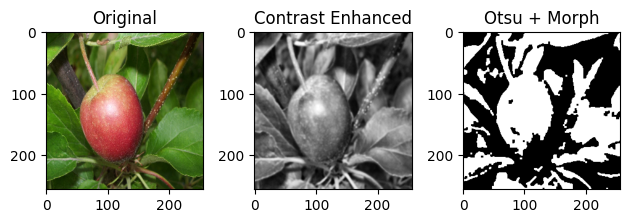

In [2]:
import matplotlib.pyplot as plt

img_path = "E:/Mariam/Uni Studing Material/L4(Second Term)/Computer Vision/project/Object Detection/openimages/apple/images/f765ed1b79eb1f1e.jpg"
image = cv2.imread(img_path)
results = preprocess_image(image)

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(results["resized"], cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Contrast Enhanced")
plt.imshow(results["contrast"], cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Otsu + Morph")
plt.imshow(results["binary"], cmap='gray')

plt.tight_layout()
plt.show()


## 2. Segmentation 

In [3]:
import cv2
import numpy as np
# Region Growing Function
def region_growing(img, seed, threshold=5):
    height, width = img.shape
    segmented = np.zeros_like(img)
    visited = np.zeros_like(img, dtype=bool)
    stack = [seed]
    seed_value = img[seed]

    while stack:
        x, y = stack.pop()
        if visited[x, y]:
            continue
        visited[x, y] = True
        if abs(int(img[x, y]) - int(seed_value)) < threshold:
            segmented[x, y] = 255
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < height and 0 <= ny < width:
                        stack.append((nx, ny))
    return segmented


In [4]:
# Watershed Segmentation
def watershed_segmentation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological cleanup
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Background and foreground
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Markers
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Apply watershed
    img_color = img.copy()
    markers = cv2.watershed(img_color, markers)

    # Draw red boundaries on the original image
    img_color[markers == -1] = [0, 0, 255]

    return img_color



In [5]:
# Modular Segmentation Function
import cv2
import numpy as np

def segment_image(image_dict, method="otsu"):
    """
    Segment an image using the selected method.
    - image_dict: output from preprocess_image
    - method: one of ['otsu', 'canny', 'kmeans', 'region_growing', 'watershed']
    """
    if method == "otsu":
        return image_dict["binary"]

    elif method == "canny":
        edges = cv2.Canny(image_dict["gray"], 100, 200)
        return edges

    elif method == "kmeans":
        img = image_dict["resized"]
        Z = img.reshape((-1, 3))
        Z = np.float32(Z)

        # KMeans criteria and clustering
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = 3
        _, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Reconstruct clustered image
        centers = np.uint8(centers)
        clustered = centers[labels.flatten()].reshape(img.shape)
        return cv2.cvtColor(clustered, cv2.COLOR_BGR2GRAY)

    elif method == "region_growing":
        seed = (image_dict["gray"].shape[0] // 2, image_dict["gray"].shape[1] // 2)
        return region_growing(image_dict["gray"], seed)

    elif method == "watershed":
        return watershed_segmentation(image_dict["resized"])

    else:
        raise ValueError("Unsupported segmentation method.")



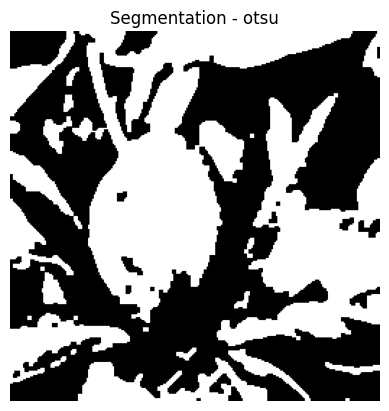

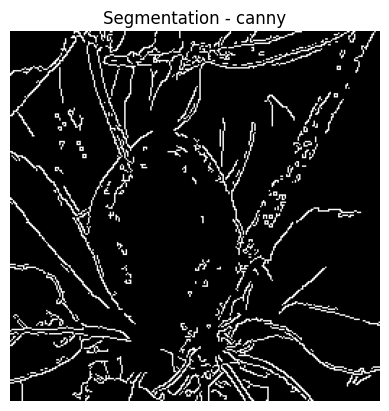

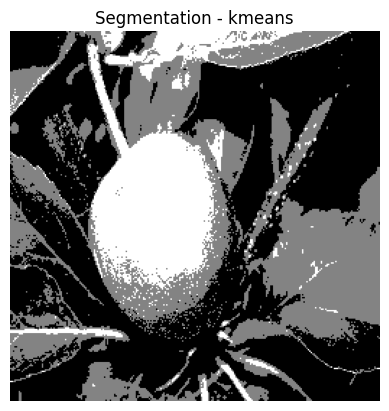

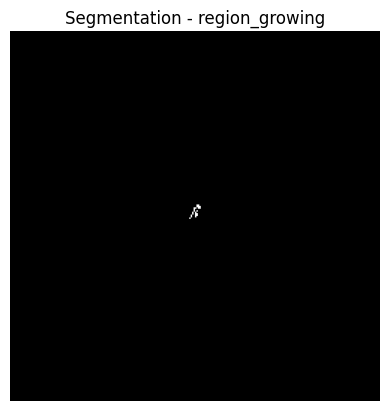

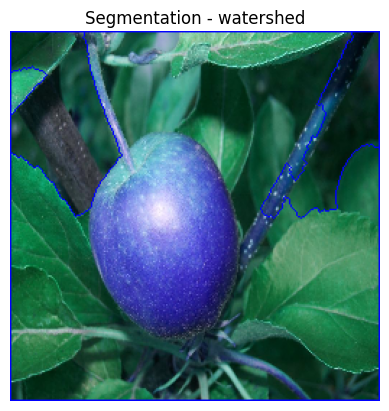

In [6]:
# Testing All Methods on One Image To chose the best one
methods = ["otsu", "canny", "kmeans", "region_growing", "watershed"]
for method in methods:
    segmented = segment_image(results, method)
    plt.imshow(segmented, cmap='gray')
    plt.title(f"Segmentation - {method}")
    plt.axis('off')
    plt.show()


### Based on the output the best way is watershed



## 3. Feature Extraction

    1. Read image and corresponding XML.

    2. Crop each annotated object ROI.

    3. Apply watershed segmentation to the ROI.

    4. Extract features from segmented ROI.

    5. Save feature vector and label.

In [ ]:

import os
import cv2
import numpy as np
from tqdm import tqdm

# Function to process the dataset
def process_dataset(input_root, output_root):
    os.makedirs(output_root, exist_ok=True)

    for subdir, _, files in os.walk(input_root):
        for filename in tqdm(files):
            if filename.lower().endswith(('.jpg', '.png')):
                input_path = os.path.join(subdir, filename)

                relative_path = os.path.relpath(subdir, input_root)
                output_subdir = os.path.join(output_root, relative_path)
                os.makedirs(output_subdir, exist_ok=True)

                out_path = os.path.join(output_subdir, filename)

                img = cv2.imread(input_path)
                if img is None:
                    continue

                segmented = watershed_segmentation(img)
                cv2.imwrite(out_path, segmented)


input_root = "E:/Mariam/Uni Studing Material/L4(Second Term)/Computer Vision/project/Object Detection/openimages"
output_root = "E:/Mariam/Uni Studing Material/L4(Second Term)/Computer Vision/project/Object Detection/openimages/openimages_masks"
process_dataset(input_root, output_root)


In [7]:
# Cropping ROIs based on XML bounding boxes
# So that feature extraction is focused only on labeled objects, not the full image.
import xml.etree.ElementTree as ET
import os
import cv2

def parse_pascal_voc(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    objects = []

    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        objects.append((label, xmin, ymin, xmax, ymax))

    return objects


In [8]:
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
import numpy as np

def extract_features(image):
    # Convert to grayscale and HSV
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    features = []

    # 1. Color Histogram (HSV)
    for i in range(3):  # H, S, V
        hist = cv2.calcHist([hsv], [i], None, [32], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)

    # 2. Texture: Local Binary Pattern
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    (hist_lbp, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist_lbp = hist_lbp.astype("float")
    hist_lbp /= (hist_lbp.sum() + 1e-6)
    features.extend(hist_lbp)

    # 3. Texture: GLCM Properties
    glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
    features.append(graycoprops(glcm, 'contrast')[0, 0])
    features.append(graycoprops(glcm, 'correlation')[0, 0])
    features.append(graycoprops(glcm, 'homogeneity')[0, 0])
    features.append(graycoprops(glcm, 'ASM')[0, 0])

    # 4. Shape Features from largest contour
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = float(w) / h
        features.extend([area, perimeter, aspect_ratio])
    else:
        features.extend([0, 0, 0])


    return np.array(features)


In [9]:
def draw_bounding_boxes(img, objects):
    for label, xmin, ymin, xmax, ymax in objects:
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (36, 255, 12), 2)
    return img

In [10]:
# Process all images for ML & DL
def unified_data_processing(image_dir, annotation_dir, label_map, target_size=(64, 64)):
    images = []
    labels = []
    features_list = []

    for filename in tqdm(os.listdir(image_dir), desc=f"Processing {os.path.basename(image_dir)}"):
        if not filename.endswith(('.jpg', '.png')):
            continue

        image_path = os.path.join(image_dir, filename)
        xml_path = os.path.join(annotation_dir, os.path.splitext(filename)[0] + ".xml")

        if not os.path.exists(xml_path):
            continue

        img = cv2.imread(image_path)
        if img is None:
            continue

        objects = parse_pascal_voc(xml_path)

        for label, xmin, ymin, xmax, ymax in objects:
            if label not in label_map:
                print(f"Skipping unknown label: {label}")
                continue

            roi = img[ymin:ymax, xmin:xmax]
            segmented = watershed_segmentation(roi)
            if segmented.shape[0] == 0 or segmented.shape[1] == 0:
                continue

            # For CNN
            resized = cv2.resize(segmented, target_size)
            images.append(resized)

            # For traditional ML model
            features = extract_features(segmented)  # Apply feature extraction
            if features is not None and len(features) > 0:
                features_list.append(features)

            # Store label
            labels.append(label_map[label])
    
    return np.array(images), np.array(features_list), np.array(labels)


In [11]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


label_map = {'apple': 0, 'banana': 1, 'car': 2, 'dog': 3, 'person': 4, 'bicycle': 5, 'chair': 6}
categories = list(label_map.keys())
# Use raw string
# Escape each backslash (less clean)
root_dir = "E:\\Mariam\\Uni Studing Material\\L4(Second Term)\\Computer Vision\\project\\Object Detection\\openimages"



images = []
features = []
labels = []

for category in categories:
    image_dir = os.path.join(root_dir, category, 'images')
    annotation_dir = os.path.join(root_dir, category, 'pascal')

    imgs, ftrs, lbls = unified_data_processing(image_dir, annotation_dir, label_map)
    images.extend(imgs)
    features.extend(ftrs)
    labels.extend(lbls)

images = np.array(images)
features = np.array(features)
labels = np.array(labels)

# CNN Preparation
labels_cat = to_categorical(labels, num_classes=len(label_map))




Processing images: 100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]


C:\Users\marim\AppData\Local\Temp\ipykernel_18072\1125424709.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=label_counts, palette="viridis")


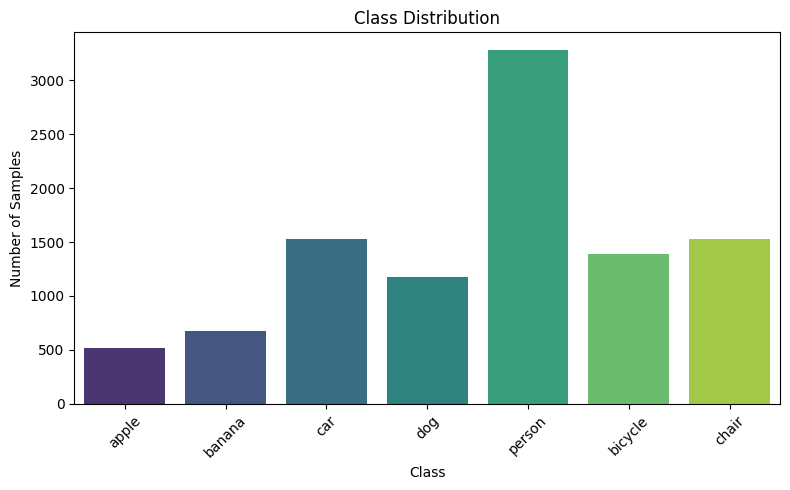

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count label distribution
label_counts = np.bincount(labels)
label_names = list(label_map.keys())

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=label_names, y=label_counts, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from collections import defaultdict

# Convert features, labels, images to NumPy arrays if not already
features = np.array(features)
labels = np.array(labels)
images = np.array(images)

# Group indices by class
class_indices = defaultdict(list)
for idx, label in enumerate(labels):
    class_indices[label].append(idx)

# Get minimum class size
min_samples = min(len(indices) for indices in class_indices.values())
print(f"Each class will be undersampled to {min_samples} samples.")

# Sample equal number from each class
balanced_indices = []
for indices in class_indices.values():
    balanced_indices.extend(np.random.choice(indices, min_samples, replace=False))

# Shuffle selected indices
np.random.shuffle(balanced_indices)

# Create balanced dataset
features = features[balanced_indices]
labels = labels[balanced_indices]
images = images[balanced_indices]


Each class will be undersampled to 521 samples.


C:\Users\marim\AppData\Local\Temp\ipykernel_18072\1028272360.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=label_counts_balanced, palette="viridis")


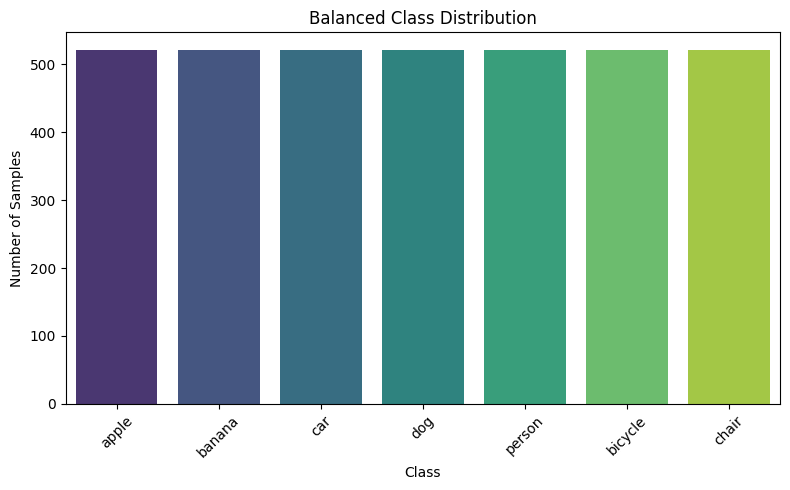

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

label_counts_balanced = np.bincount(labels)
label_names = list(label_map.keys())

plt.figure(figsize=(8, 5))
sns.barplot(x=label_names, y=label_counts_balanced, palette="viridis")
plt.title("Balanced Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Classification 

Techniques:

1. Traditional ML: Support Vector Classification. (SVC)

2. Deep Learning:

    - Custom Convolutional Neural Network (CNN)
    - Pretrained MobileNetV2


Test Accuracy: 71.32%

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       114
           1       0.68      0.71      0.70       138
           2       0.86      0.80      0.83       298
           3       0.65      0.60      0.62       248
           4       0.70      0.85      0.77       648
           5       0.71      0.58      0.64       261
           6       0.67      0.59      0.62       312

    accuracy                           0.71      2019
   macro avg       0.72      0.68      0.69      2019
weighted avg       0.71      0.71      0.71      2019



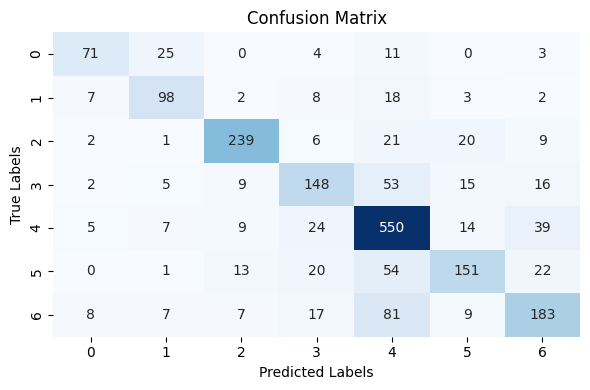

In [27]:
# ML Model: SVC Classifier


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns



X = np.array(features)
y = np.array(labels)

# 2. Preprocessing
X_scaled = StandardScaler().fit_transform(X)

# 3. Split dataset
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. Train SVC Classifier
clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(X_train_ml, y_train_ml)

# 5. Evaluate
y_pred_ml = clf.predict(X_test_ml)

# Print accuracy
accuracy = accuracy_score(y_test_ml, y_pred_ml)
print(f"\nTest Accuracy: {accuracy:.2%}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_ml, y_pred_ml))

# Plot confusion matrix
cm = confusion_matrix(y_test_ml, y_pred_ml)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()





In [28]:
import joblib

# Save the trained model
joblib.dump(clf, 'svc_classifier.pkl')

['svc_classifier.pkl']

In [29]:

# Example input size: 64x64x3
def create_custom_cnn(input_shape=(64, 64, 3), num_classes=7):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [30]:


# Train/test split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(images, labels_cat, test_size=0.2, random_state=42)

# Create and train the model
model_cnn = create_custom_cnn(input_shape=(64, 64, 3), num_classes=len(label_map))
model_cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate
test_loss, test_acc = model_cnn.evaluate(X_test_cnn, y_test_cnn)
print(f"Custom CNN Test Accuracy: {test_acc:.4f}")


c:\Users\marim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.2931 - loss: 8.3035 - val_accuracy: 0.4715 - val_loss: 1.4451
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 29s 127ms/step - accuracy: 0.4470 - loss: 1.4997 - val_accuracy: 0.5644 - val_loss: 1.1790
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 32s 139ms/step - accuracy: 0.5359 - loss: 1.2550 - val_accuracy: 0.6584 - val_loss: 1.0018
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - accuracy: 0.6078 - loss: 1.0838 - val_accuracy: 0.6696 - val_loss: 0.9329
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - accuracy: 0.6657 - loss: 0.9501 - val_accuracy: 0.6745 - val_loss: 0.9150
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - accuracy: 0.6958 - loss: 0.8826 - val_accuracy: 0.6906 - val_loss: 0.8983
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - accuracy: 0.7236 - loss: 0.7709 - val_accuracy: 0.7104 - val_loss: 0.8593
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - accuracy: 0.7423 - loss: 0.

In [31]:
model_cnn.save("custom_cnn_model.h5")

In [32]:
# Load required libraries for MobileNet and visualization
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels_cat, test_size=0.2, random_state=42)

# Define MobileNetV2 model
def create_mobilenet_model(input_shape=(64, 64, 3), num_classes=7):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

    model_mobilenet.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_mobilenet

mobilenet_model = create_mobilenet_model(input_shape=(64, 64, 3), num_classes=7)
mobilenet_model.summary()

# Train model
mobilenet_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate
test_loss, test_acc = mobilenet_model.evaluate(X_test, y_test)
test_acc



C:\Users\marim\AppData\Local\Temp\ipykernel_18072\2573489439.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 2,232,839 (8.52 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/5


c:\Users\marim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(32, 64, 64, 3))
  warnings.warn(msg)


227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6886 - loss: 0.9786

c:\Users\marim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(None, 64, 64, 3))
  warnings.warn(msg)


227/227 ━━━━━━━━━━━━━━━━━━━━ 157s 369ms/step - accuracy: 0.6889 - loss: 0.9776 - val_accuracy: 0.5124 - val_loss: 9.7963
Epoch 2/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 106s 466ms/step - accuracy: 0.8504 - loss: 0.4520 - val_accuracy: 0.7574 - val_loss: 1.9231
Epoch 3/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 111s 486ms/step - accuracy: 0.8696 - loss: 0.3998 - val_accuracy: 0.3837 - val_loss: 5.5403
Epoch 4/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 113s 500ms/step - accuracy: 0.8191 - loss: 0.5494 - val_accuracy: 0.2376 - val_loss: 11.5013
Epoch 5/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 116s 509ms/step - accuracy: 0.8114 - loss: 0.5850 - val_accuracy: 0.5842 - val_loss: 3.3661
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.5901 - loss: 3.1521


0.5765230059623718

In [33]:
mobilenet_model.save("mobilenet_model.keras")

In [34]:
# Compare Accuracy

print(f"SVC Accuracy: 71.32 % ")
print(f"Custom CNN Accuracy: 73.65 %")
print(f"MobileNetV2 Accuracy: 57.65 %")

SVC Accuracy: 71.32 % 
Custom CNN Accuracy: 73.65 %
MobileNetV2 Accuracy: 57.65 %


### We will use CNN to show example

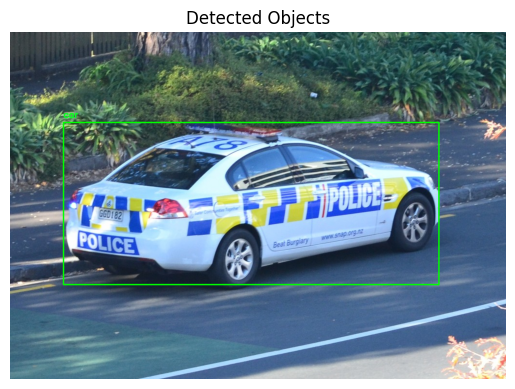

In [35]:
import matplotlib.pyplot as plt  
from utils import *

# openimages/banana/images/cc7497f20d88361a.jpg

image_path = "E:/Mariam/Uni Studing Material/L4(Second Term)/Computer Vision/project/Object Detection/openimages/car/images/00e82dca4d06bd93.jpg"
xml_path = "E:/Mariam/Uni Studing Material/L4(Second Term)/Computer Vision/project/Object Detection/openimages/car/pascal/00e82dca4d06bd93.xml"
image = cv2.imread(image_path)
objects = parse_pascal_voc(xml_path)
boxed = draw_bounding_boxes(image.copy(), objects)
plt.imshow(cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB))
plt.title("Detected Objects")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


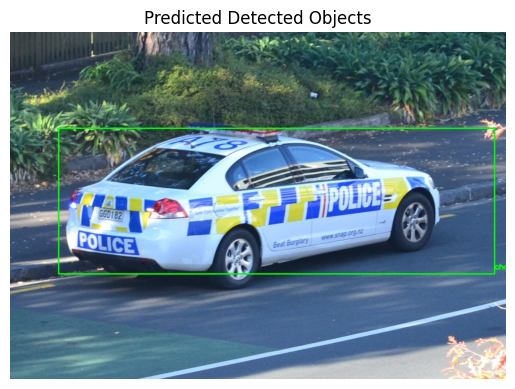

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

# Function to preprocess image for the CNN model
def preprocess_image_for_cnn(image_path, target_size=(64, 64)):
    image = cv2.imread(image_path)
    # Resize and normalize the image as the CNN expects
    resized_image = cv2.resize(image, target_size)
    image_array = img_to_array(resized_image) / 255.0
    return np.expand_dims(image_array, axis=0)

# Function to show image with bounding box
def plot_image_with_predicted_boxes(image, label, bounding_box):
    labeled_image = image.copy()
    xmin, ymin, xmax, ymax = bounding_box
    cv2.rectangle(labeled_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    cv2.putText(labeled_image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
    plt.title("Predicted Detected Objects")
    plt.axis('off')
    plt.show()
    
#openimages/dog/images/0ae28b5f3d9513a0.jpg
# Load and preprocess the image
image_path = "openimages/car/images/00e82dca4d06bd93.jpg"
preprocessed_image = preprocess_image_for_cnn(image_path)

# Make a prediction with your CNN model (e.g., by passing preprocessed_image through the model)
predictions = model_cnn.predict(preprocessed_image)

# Here I will determine my bounding boxes and labels based on my model's output.
# This part will be specific to how your model's output is structured.

label_map_inverse = {v: k for k, v in label_map.items()}
predicted_label_index = np.argmax(predictions[0])

# Example bounding box you want to show (replace with actual predictions)
example_bounding_box = (1000, 500, 100, 200)  # (xmin, ymin, xmax, ymax)
predicted_label = label_map_inverse[predicted_label_index]

# Read the original image for displaying
original_image = cv2.imread(image_path)
plot_image_with_predicted_boxes(original_image, predicted_label, example_bounding_box)